2025-04-06 01:42:34 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-04-06 01:42:35 - vnstock.explorer.tcbs.quote - ERROR - Dữ liệu không tồn tại từ 2006-02-05 đến 2007-01-31: Input data is empty or not provided.
2025-04-06 01:42:35 - vnstock.explorer.tcbs.quote - ERROR - Dữ liệu không tồn tại từ 2007-02-01 đến 2008-01-31: Input data is empty or not provided.
2025-04-06 01:42:35 - vnstock.explorer.tcbs.quote - ERROR - Dữ liệu không tồn tại từ 2008-02-01 đến 2009-01-31: Input data is empty or not provided.


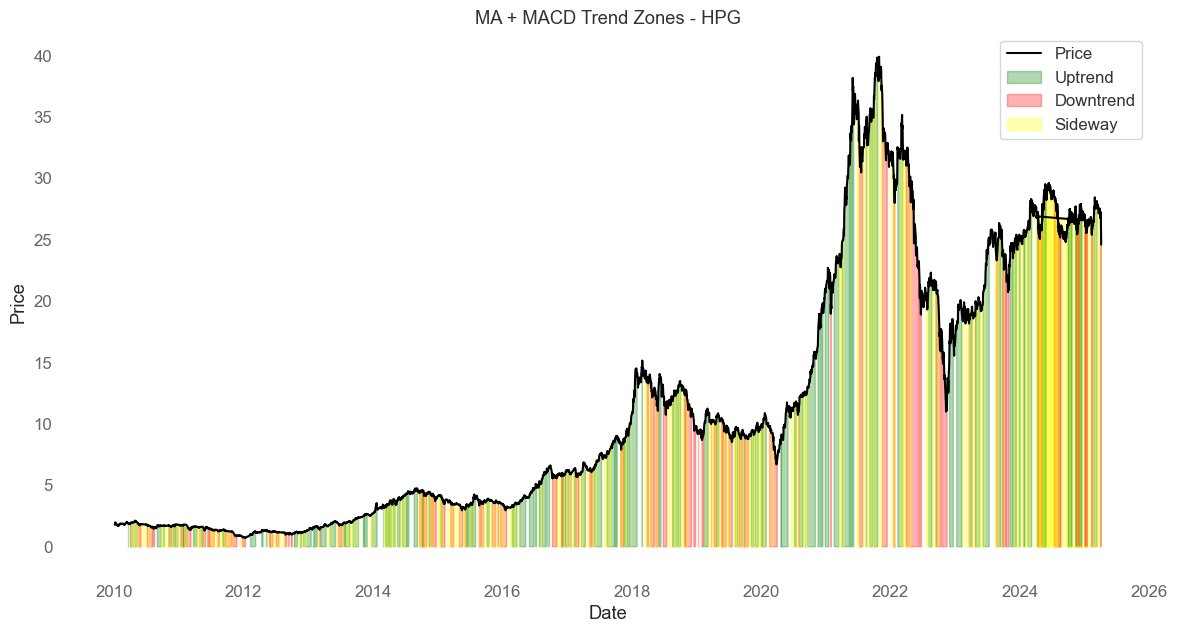

In [10]:
import vectorbt as vbt
import pandas as pd
import numpy as np
from vnstock import Vnstock 
import datetime as dt
import talib
import matplotlib.pyplot as plt

# === Lấy dữ liệu ===
stock = "HPG"
vnstock_instance = Vnstock().stock(symbol=stock, source='TCBS')
end_date = dt.datetime.now().strftime('%Y-%m-%d')
start_date = (dt.datetime.now() - dt.timedelta(days=7000)).strftime('%Y-%m-%d')
df = vnstock_instance.quote.history(symbol=stock, start=start_date, end=end_date, interval='1D')

df.set_index("time", inplace=True)
df.index = pd.to_datetime(df.index)
df = df[['open', 'high', 'low', 'close', 'volume']].rename(columns={
    'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'
})

# === Tính toán chỉ báo ===
def calculate_indicators(df):
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(
        df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    return df

# === Xác định vùng xu hướng ===
def detect_trends_ma_macd(df):
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['SMA50'] = df['Close'].rolling(window=50).mean()
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    df['Uptrend'] = (df['Close'] > df['SMA20']) & (df['Close'] > df['SMA50']) & (df['MACD'] > 0) & (df['MACD'] > df['Signal'])
    df['Downtrend'] = (df['Close'] < df['SMA20']) & (df['Close'] < df['SMA50']) & (df['MACD'] < 0) & (df['MACD'] < df['Signal'])

    bb_width_threshold = 0.15
    adx_threshold = 30
    atr_threshold = df['ATR'].rolling(window=50).mean() * 1.2
    df['Sideway_BB'] = df['BB_width'] < bb_width_threshold
    df['Sideway_ADX'] = df['ADX'] < adx_threshold
    df['Sideway_ATR'] = df['ATR'] < atr_threshold
    df['Sideway_All'] = df['Sideway_BB'] & df['Sideway_ADX'] & df['Sideway_ATR']

    # Xử lý NaN
    df[['Uptrend', 'Downtrend', 'Sideway_All']] = df[['Uptrend', 'Downtrend', 'Sideway_All']].fillna(False)
    return df

# === Vẽ biểu đồ ===
def plot_trends(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Price', color='black')
    plt.fill_between(df.index, df['Close'], where=df['Uptrend'], color='green', alpha=0.3, label='Uptrend')
    plt.fill_between(df.index, df['Close'], where=df['Downtrend'], color='red', alpha=0.3, label='Downtrend')
    plt.fill_between(df.index, df['Close'], where=df['Sideway_All'], color='yellow', alpha=0.3, label='Sideway')
    plt.legend()
    plt.title(f'MA + MACD Trend Zones - {stock}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(False)
    plt.show()

# === Chạy code ===
df = calculate_indicators(df)
df = detect_trends_ma_macd(df)
plot_trends(df)

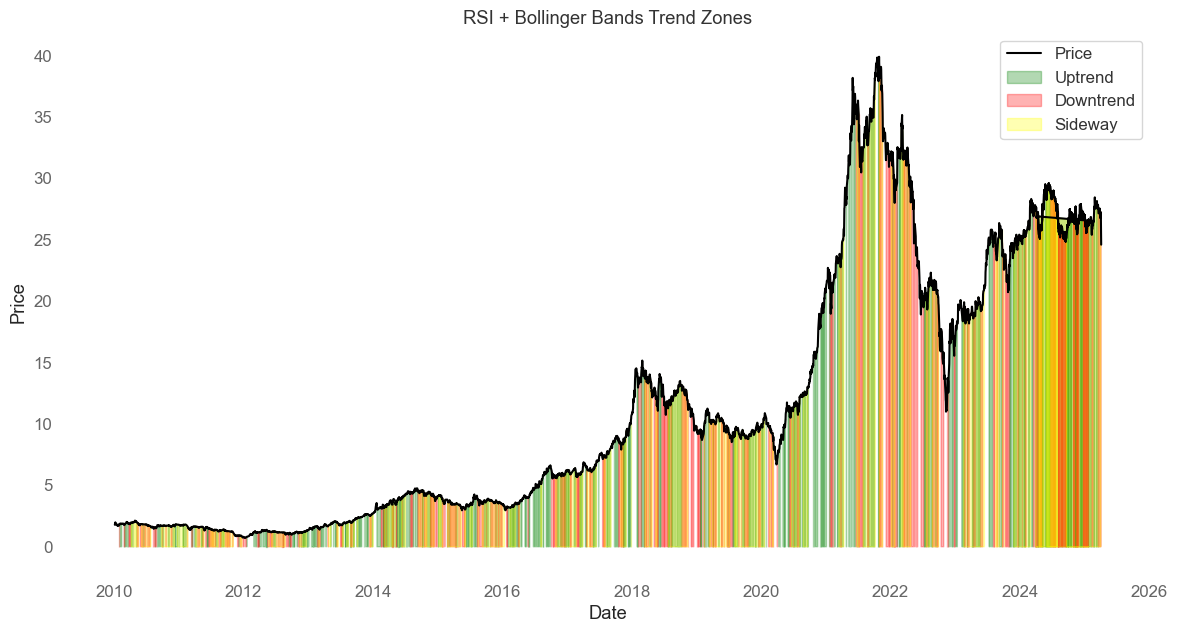

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
def calculate_indicators(df):
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(
        df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    return df
def detect_trends_rsi_bb(df):
    # Tính RSI và Bollinger Bands nếu chưa có
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    df['BB_std'] = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + 2 * df['BB_std']
    df['BB_lower'] = df['BB_middle'] - 2 * df['BB_std']
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['SMA50'] = df['Close'].rolling(window=50).mean()
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    df['Uptrend'] = (df['Close'] > df['SMA20']) & (df['Close'] > df['SMA50']) & (df['MACD'] > 0) & (df['MACD'] > df['Signal'])

    # Xác định vùng Uptrend
    df['Uptrend'] = ((df['RSI'] > 50) & (df['RSI'] < 70) & (df['Close'] > df['BB_middle']) 
                     & (df['Close'] <= df['BB_upper']))|((df['Close'] > df['SMA20']) & (df['Close'] > df['SMA50']) & (df['MACD'] > 0) & (df['MACD'] > df['Signal'])

    # Xác định vùng Downtrend
    df['Downtrend'] = (df['RSI'] < 50) & (df['RSI'] > 30) & (df['Close'] < df['BB_middle']) & (df['Close'] >= df['BB_lower'])

    # Xác định vùng Sideway
    bb_width_threshold = 0.15
    adx_threshold = 30
    atr_threshold = df['ATR'].rolling(window=50).mean() * 1.2
    df['Sideway_BB'] = df['BB_width'] < bb_width_threshold
    df['Sideway_ADX'] = df['ADX'] < adx_threshold
    df['Sideway_ATR'] = df['ATR'] < atr_threshold
    df['Sideway_All'] = df['Sideway_BB'] & df['Sideway_ADX'] & df['Sideway_ATR']

    return df

def plot_trends(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Price', color='black')
    plt.fill_between(df.index, df['Close'], where=df['Uptrend'], color='green', alpha=0.3, label='Uptrend')
    plt.fill_between(df.index, df['Close'], where=df['Downtrend'], color='red', alpha=0.3, label='Downtrend')
    plt.fill_between(df.index, df['Close'], where=df['Sideway_All'], color='yellow', alpha=0.3, label='Sideway')
    plt.legend()
    plt.title('RSI + Bollinger Bands Trend Zones')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(False)
    plt.show()

# plot_trends(df)
df = calculate_indicators(df)
df = detect_trends_rsi_bb(df)
plot_trends(df)

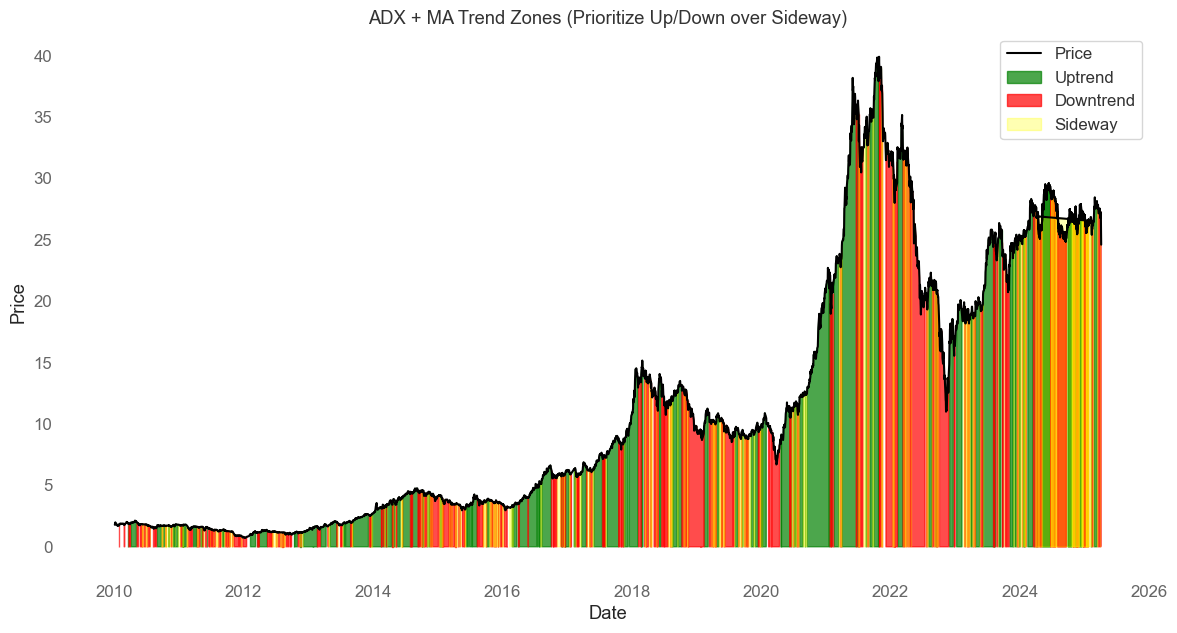

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

import talib  # Đảm bảo đã import talib

def calculate_indicators(df):
    # Bollinger Bands
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    
    # ADX và các thành phần
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['+DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['-DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)

    # ATR
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    
    return df

def detect_trends_adx_ma(df):
    # Tính ADX và MA nếu chưa có (giả định ADX đã có, nếu không cần thêm thư viện ta-lib)
    df['SMA200'] = df['Close'].rolling(window=200).mean()
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    df['BB_std'] = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + 2 * df['BB_std']
    df['BB_lower'] = df['BB_middle'] - 2 * df['BB_std']
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    
    # Xác định vùng Uptrend
    df['Uptrend'] = ((df['ADX'] >= 25) & (df['+DI'] > df['-DI']) 
                     & (df['Close'] > df['SMA200'])) | ((df['Close'] > df['SMA20']) & (df['Close'] > df['SMA50']) & (df['MACD'] > 0) & (df['MACD'] > df['Signal']))

    # Xác định vùng Downtrend
    df['Downtrend'] = ((df['ADX'] >= 25) & (df['-DI'] > df['+DI']) 
                       & (df['Close'] < df['SMA200'])) | ((df['RSI'] < 50) & (df['RSI'] > 30) & (df['Close'] < df['BB_middle']) & (df['Close'] >= df['BB_lower']))
    

    # Xác định vùng Sideway
    bb_width_threshold = 0.15
    adx_threshold = 25
    atr_threshold = df['ATR'].rolling(window=50).mean() * 1.2
    df['Sideway_BB'] = df['BB_width'] < bb_width_threshold
    df['Sideway_ADX'] = df['ADX'] < adx_threshold
    df['Sideway_ATR'] = df['ATR'] < atr_threshold
    df['Sideway_All'] = ((~df['Uptrend']) & (~df['Downtrend'])) & (df['Sideway_BB'] & df['Sideway_ADX'] & df['Sideway_ATR'])

    return df

def plot_trends(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Price', color='black')

    # Giữ nguyên các vùng như cũ
    uptrend = df['Uptrend']
    downtrend = df['Downtrend']
    sideway_only = df['Sideway_All'] & ~uptrend & ~downtrend  # Loại trừ vùng trùng

    # Ưu tiên vẽ: Uptrend > Downtrend > Sideway
    plt.fill_between(df.index, df['Close'], where=uptrend, color='green', alpha=0.7, label='Uptrend')
    plt.fill_between(df.index, df['Close'], where=downtrend, color='red', alpha=0.7, label='Downtrend')
    plt.fill_between(df.index, df['Close'], where=sideway_only, color='yellow', alpha=0.3, label='Sideway')

    plt.legend()
    plt.title('ADX + MA Trend Zones (Prioritize Up/Down over Sideway)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(False)
    plt.show()


df = calculate_indicators(df)
df = detect_trends_adx_ma(df)

plot_trends(df)
# plot_trends(df)

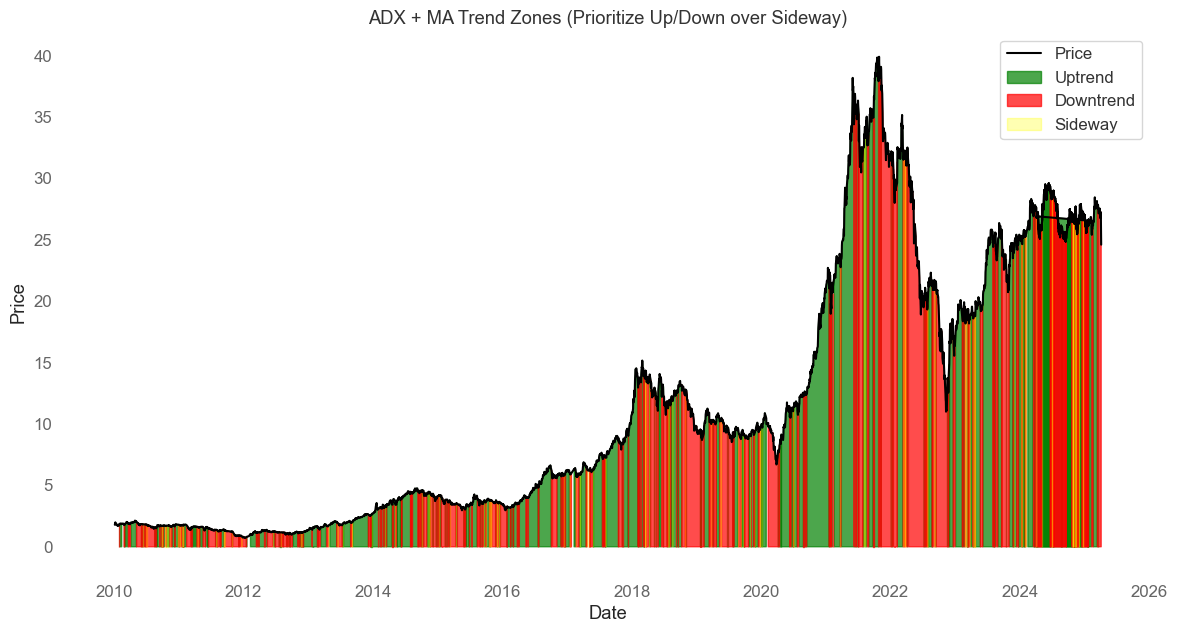

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import talib  # Đảm bảo đã import talib

def calculate_indicators(df):
    # Bollinger Bands
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    
    # ADX và các thành phần
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['+DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['-DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)

    # ATR
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

    # SMA20 và SMA50 (dùng cho điều kiện Uptrend)
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['SMA50'] = df['Close'].rolling(window=50).mean()

    # MACD
    df['MACD'], df['Signal'], _ = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    # Stochastic Oscillator
    df['Stoch_%K'], df['Stoch_%D'] = talib.STOCH(
        df['High'], df['Low'], df['Close'], 
        fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0
    )

    # Ichimoku Cloud
    # Tenkan-sen (Conversion Line)
    high_9 = df['High'].rolling(window=9).max()
    low_9 = df['Low'].rolling(window=9).min()
    df['Ichimoku_Tenkan'] = (high_9 + low_9) / 2

    # Kijun-sen (Base Line)
    high_26 = df['High'].rolling(window=26).max()
    low_26 = df['Low'].rolling(window=26).min()
    df['Ichimoku_Kijun'] = (high_26 + low_26) / 2

    # Senkou Span A (Leading Span A)
    df['Ichimoku_SpanA'] = ((df['Ichimoku_Tenkan'] + df['Ichimoku_Kijun']) / 2).shift(26)

    # Senkou Span B (Leading Span B)
    high_52 = df['High'].rolling(window=52).max()
    low_52 = df['Low'].rolling(window=52).min()
    df['Ichimoku_SpanB'] = ((high_52 + low_52) / 2).shift(26)

    # Parabolic SAR
    df['Parabolic_SAR'] = talib.SAR(df['High'], df['Low'], acceleration=0.02, maximum=0.2)

    return df

def detect_trends_adx_ma(df):
    # Tính các chỉ báo cần thiết nếu chưa có
    df['SMA200'] = df['Close'].rolling(window=200).mean()
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands (nếu chưa có từ calculate_indicators)
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    df['BB_std'] = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + 2 * df['BB_std']
    df['BB_lower'] = df['BB_middle'] - 2 * df['BB_std']
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']

    # Xác định vùng Uptrend (kết hợp các chỉ báo mới)
    df['Uptrend'] = (
        # Điều kiện cũ
        ((df['ADX'] >= 25) & (df['+DI'] > df['-DI']) & (df['Close'] > df['SMA200'])) |
        ((df['Close'] > df['SMA20']) & (df['Close'] > df['SMA50']) & (df['MACD'] > 0) & (df['MACD'] > df['Signal'])) |
        ((df['RSI'] > 50) & (df['RSI'] < 70) & (df['Close'] > df['BB_middle']) 
                     & (df['Close'] <= df['BB_upper']))|
        # Điều kiện mới
        ((df['Stoch_%K'] > df['Stoch_%D']) & (df['Stoch_%K'] < 80) & (df['Stoch_%K'] > 50))   # Stochastic
    )

    # Xác định vùng Downtrend (kết hợp các chỉ báo mới)
    df['Downtrend'] = (
        # Điều kiện cũ
        ((df['ADX'] >= 25) & (df['-DI'] > df['+DI']) & (df['Close'] < df['SMA200'])) |
        ((df['Close'] < df['SMA20']) & (df['Close'] < df['SMA50']) & (df['MACD'] < 0) & (df['MACD'] < df['Signal'])) |
        ((df['RSI'] < 50) & (df['RSI'] > 30) & (df['Close'] < df['BB_middle']) & (df['Close'] >= df['BB_lower'])) |
        # Điều kiện mới
        ((df['Stoch_%K'] < df['Stoch_%D']) & (df['Stoch_%K'] > 20) & (df['Stoch_%K'] < 50))  # Stochastic
    )

    # Xác định vùng Sideway
    bb_width_threshold = 0.15
    adx_threshold = 25
    atr_threshold = df['ATR'].rolling(window=50).mean() * 1.2
    df['Sideway_BB'] = df['BB_width'] < bb_width_threshold
    df['Sideway_ADX'] = df['ADX'] < adx_threshold
    df['Sideway_ATR'] = df['ATR'] < atr_threshold
    df['Sideway_All'] = ((~df['Uptrend']) & (~df['Downtrend'])) & (df['Sideway_BB'] & df['Sideway_ADX'] & df['Sideway_ATR'])

    return df

def plot_trends(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Price', color='black')

    # Giữ nguyên các vùng như cũ
    uptrend = df['Uptrend']
    downtrend = df['Downtrend']
    sideway_only = df['Sideway_All'] & ~uptrend & ~downtrend  # Loại trừ vùng trùng

    # Ưu tiên vẽ: Uptrend > Downtrend > Sideway
    plt.fill_between(df.index, df['Close'], where=uptrend, color='green', alpha=0.7, label='Uptrend')
    plt.fill_between(df.index, df['Close'], where=downtrend, color='red', alpha=0.7, label='Downtrend')
    plt.fill_between(df.index, df['Close'], where=sideway_only, color='yellow', alpha=0.3, label='Sideway')

    plt.legend()
    plt.title('ADX + MA Trend Zones (Prioritize Up/Down over Sideway)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(False)
    plt.show()

# Giả định df đã được định nghĩa (có các cột 'High', 'Low', 'Close', 'Volume')
# df = pd.DataFrame(...)  # Bạn cần cung cấp dữ liệu thực tế
df = calculate_indicators(df)
df = detect_trends_adx_ma(df)
plot_trends(df)

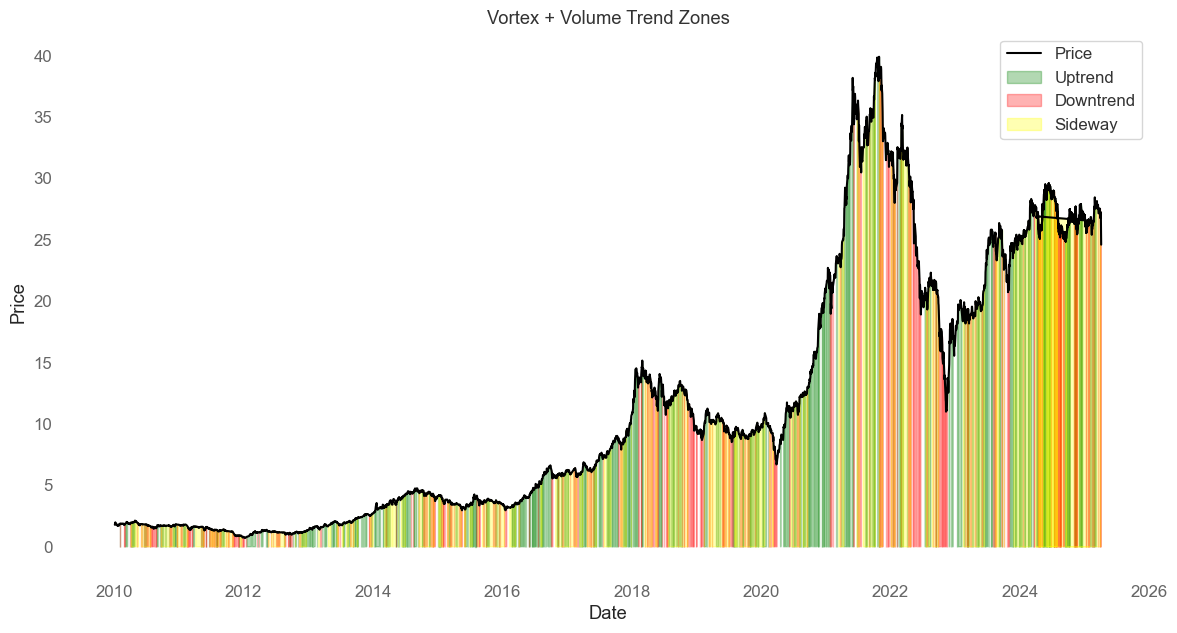

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

import talib  # Nhớ import talib nếu chưa có

def calculate_indicators(df):
    # Bollinger Bands
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(
        df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']

    # ADX & ATR
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

    # Vortex Indicator (+VI, -VI)
    high = df['High']
    low = df['Low']
    close = df['Close']
    n = 14  # timeperiod

    df['TR'] = pd.concat([
        (high - low).abs(),
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ], axis=1).max(axis=1)

    df['+VM'] = (high - low.shift()).abs()
    df['-VM'] = (low - high.shift()).abs()

    df['+VI'] = df['+VM'].rolling(window=n).sum() / df['TR'].rolling(window=n).sum()
    df['-VI'] = df['-VM'].rolling(window=n).sum() / df['TR'].rolling(window=n).sum()

    return df

def detect_trends_vortex_volume(df):
    # Tính Vortex Indicator nếu chưa có (giả định +VI, -VI đã có)
    # Nếu không, cần dùng thư viện ta-lib hoặc tự tính
    df['Volume_MA'] = df['Volume'].rolling(window=20).mean()

    # Xác định vùng Uptrend
    df['Uptrend'] = (df['+VI'] > df['-VI']) & (df['Volume'] > df['Volume_MA'])

    # Xác định vùng Downtrend
    df['Downtrend'] = (df['-VI'] > df['+VI']) & (df['Volume'] > df['Volume_MA'])

    # Xác định vùng Sideway
    bb_width_threshold = 0.15
    adx_threshold = 30
    atr_threshold = df['ATR'].rolling(window=50).mean() * 1.2
    df['Sideway_BB'] = df['BB_width'] < bb_width_threshold
    df['Sideway_ADX'] = df['ADX'] < adx_threshold
    df['Sideway_ATR'] = df['ATR'] < atr_threshold
    df['Sideway_All'] = df['Sideway_BB'] & df['Sideway_ADX'] & df['Sideway_ATR']

    return df

def plot_trends(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Price', color='black')
    plt.fill_between(df.index, df['Close'], where=df['Uptrend'], color='green', alpha=0.3, label='Uptrend')
    plt.fill_between(df.index, df['Close'], where=df['Downtrend'], color='red', alpha=0.3, label='Downtrend')
    plt.fill_between(df.index, df['Close'], where=df['Sideway_All'], color='yellow', alpha=0.3, label='Sideway')
    plt.legend()
    plt.title('Vortex + Volume Trend Zones')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(False)
    plt.show()

df = detect_trends_vortex_volume(df)
df = calculate_indicators(df)
plot_trends(df)
# plot_trends(df)

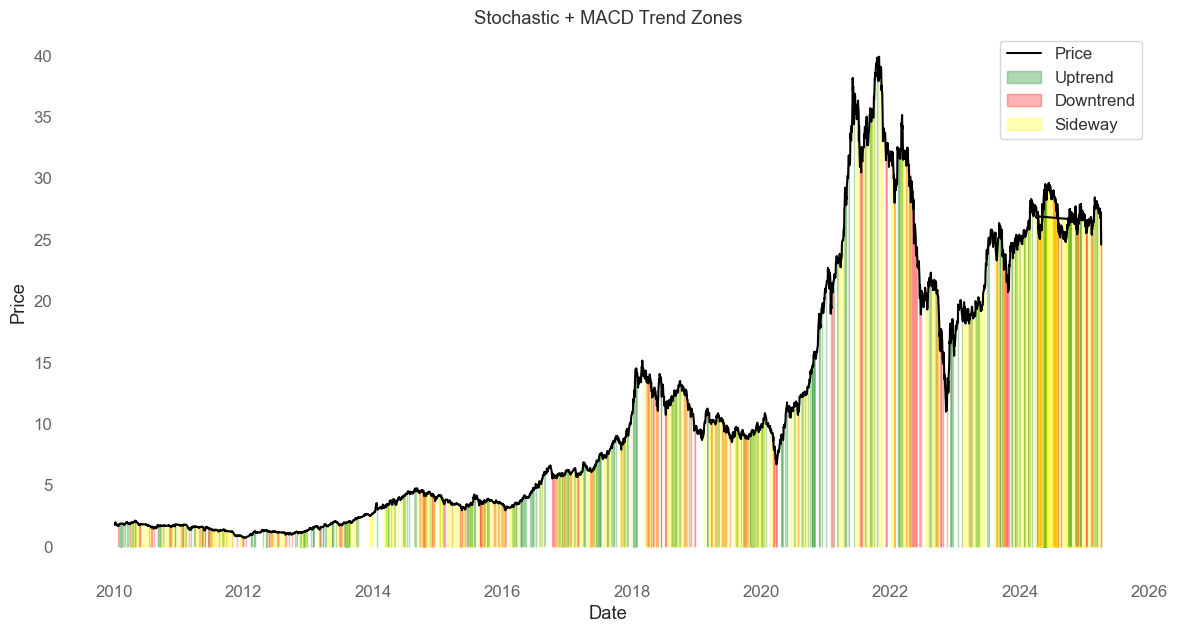

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_indicators(df):
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(
        df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    return df
def detect_trends_stoch_macd(df):
    # Tính Stochastic và MACD nếu chưa có
    df['Low_14'] = df['Low'].rolling(window=14).min()
    df['High_14'] = df['High'].rolling(window=14).max()
    df['Stoch'] = 100 * (df['Close'] - df['Low_14']) / (df['High_14'] - df['Low_14'])
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Xác định vùng Uptrend
    df['Uptrend'] = (df['Stoch'] > 50) & (df['Stoch'] < 80) & (df['MACD'] > 0) & (df['MACD'] > df['Signal'])

    # Xác định vùng Downtrend
    df['Downtrend'] = (df['Stoch'] < 50) & (df['Stoch'] > 20) & (df['MACD'] < 0) & (df['MACD'] < df['Signal'])

    # Xác định vùng Sideway
    bb_width_threshold = 0.15
    adx_threshold = 30
    atr_threshold = df['ATR'].rolling(window=50).mean() * 1.2
    df['Sideway_BB'] = df['BB_width'] < bb_width_threshold
    df['Sideway_ADX'] = df['ADX'] < adx_threshold
    df['Sideway_ATR'] = df['ATR'] < atr_threshold
    df['Sideway_All'] = df['Sideway_BB'] & df['Sideway_ADX'] & df['Sideway_ATR']

    return df

def plot_trends(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Price', color='black')
    plt.fill_between(df.index, df['Close'], where=df['Uptrend'], color='green', alpha=0.3, label='Uptrend')
    plt.fill_between(df.index, df['Close'], where=df['Downtrend'], color='red', alpha=0.3, label='Downtrend')
    plt.fill_between(df.index, df['Close'], where=df['Sideway_All'], color='yellow', alpha=0.3, label='Sideway')
    plt.legend()
    plt.title('Stochastic + MACD Trend Zones')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(False)
    plt.show()

df = detect_trends_stoch_macd(df)
# plot_trends(df)
df = calculate_indicators(df)
plot_trends(df)